This is a test notebook to produce an image from HLS using s3 urls from the LP DAAC. 

In [1]:
pip install leafmap pystac_client

Note: you may need to restart the kernel to use updated packages.


Import the python libraries required for running the script

In [1]:
import json
import leafmap
import stackstac
import xarray as xr

from pystac_client import Client


Initialize map to allow selection of desired AOI for study. Start with Pakistan for flood Visualization.

In [2]:
map = leafmap.Map(center=(33.4,-89.9), zoom=13, 
                draw_control=True, measure_control=False, fullscreen_control=False, attribution_control=True)

map

Map(center=[33.4, -89.9], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright')…

In [3]:
# Save the selected location as geojson
map.save_draw_features("bbox.geojson")

In [4]:
# Read the bounding box and print
bbox = json.load(open("bbox.geojson", "r"))
bbox

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-89.956897, 33.37357],
      [-89.956897, 33.410977],
      [-89.893211, 33.410977],
      [-89.893211, 33.37357],
      [-89.956897, 33.37357]]]}}]}

In [5]:
# Establish Connection with eoAPI

api = Client.open("https://e011yr04a1.execute-api.us-west-2.amazonaws.com")
api.title

'eoAPI-stac'

In [6]:
def preprocess(band_stack):
    """
    Preprocess provided band stack/rescale.
    """
    return band_stack.where(band_stack != -9999) * .0001

def calculate_NDVI(items, band1_name, band2_name, product, collection_name):
    """
    Calculate NDVI with NIR and RED bands:
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
    return:
        ndvi stack
    """
    stack = prepare_stack(items, product, collection_name)
    band1, band2 = stack.sel(band=band1_name), stack.sel(band=band2_name)
    ndvi = (band1 - band2) / (band1 + band2)
    ndvi = ndvi.persist()
    return ndvi

def calculate_EVI(items, band1_name, band2_name, band3_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
        band3_name: NIR band name for the stack
    return:
        EVI stack
    """
    stack = prepare_stack(items, 'EVI', collection_name)
    band1, band2, band3 = stack.sel(band=band1_name), stack.sel(band=band2_name), stack.sel(band=band3_name)
    evi = 2.5 * ((band1 - band2) / (band1 + 6.0 * band2 - 7.5 * band3 + 1.0))
    evi = evi.persist()
    return evi

def calculate_SAVI(items, band1_name, band2_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
    return:
        SAVI stack
    """
    stack = prepare_stack(items, 'EVI', collection_name)
    band1, band2 = stack.sel(band=band1_name), stack.sel(band=band2_name)
    savi = ((band1 - band2) / (band1 + band2 + 0.5)) * 1.5
    savi = savi.persist()
    return savi

def calculate_MSAVI(items, band1_name, band2_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
    return:
        MSAVI stack
    """
    stack = prepare_stack(items, 'MSAVI', collection_name)
    band1, band2 = stack.sel(band=band1_name), stack.sel(band=band2_name)
    msavi = (2.0 * band1 + 1.0 - np.sqrt((2.0 * band1 + 1.0)**2.0 - 8.0 * (band1 - band2))) / 2.0
    msavi = msavi.persist()
    return msavi

def calculate_TVI(items, band1_name, band2_name, band3_name, collection_name):
    """
    Calculate ...
    Args:
        band1_name: NIR band name for the stack
        band2_name: Red band name for the stack
        band3_name: NIR band name for the stack
    return:
        TVI stack
    """
    stack = prepare_stack(items, 'TVI', collection_name)
    band1, band2, band3 = stack.sel(band=band1_name), stack.sel(band=band2_name), stack.sel(band=band3_name)
    tvi = 0.5 * (120. * (band1 - band2) - 200. * (band3 - band2))
    tvi = tvi.persist()
    return tvi

In [7]:
# Define all related data.

EVENT_DETAILS = {
    'pakistan_flood': {
        'start_date': '2022-05-19T00:00:00Z',
        'end_date': '2022-10-18T00:00:00Z',
        'collections': ['HLSL30', 'HLSS30']
    },
    'mongolian_fire': {
        'start_date': '2022-04-19T00:00:00Z',
        'end_date': '2022-04-19T23:59:59Z',
        'collections': ['HLSL30']
    },
    'mississippi_tornado': {
        'start_date': '2023-02-19T00:00:00Z',
        'end_date': '2023-04-20T23:59:59Z',
        'collections': ['HLSL30', 'HLSS30']
    },
    'new_mexico_black_fire': {
        'start_date': '2020-05-16T00:00:00Z',
        'end_date': '2023-06-10T23:59:59Z',
        'collections': ['HLSL30', 'HLSS30']
    }
}

DERIVED_PRODUCTS = {
    "NDVI":{
        "HLSS30": ["B8A","B04"],
        "HLSL30": ["B05","B04"],
        "exec": calculate_NDVI
    },
    "EVI":{
        "HLSS30": ["B8A", "B04", "B02"],
        "HLSL30": ["B05", "B04", "B02"],
        "exec": calculate_EVI
    },
    "SAVI":{
        "HLSS30": ["B8A", "B04"],
        "HLSL30": ["B05", "B04"],
        "exec": calculate_SAVI
    },
    "MSAVI":{
        "HLSS30": ["B8A", "B04"],
        "HLSL30": ["B05", "B04"],
        "exec": calculate_MSAVI
    },
    "NDMI":{
        "HLSS30": ["B8A", "B11"],
        "HLSL30": ["B05", "B06"],
        "exec": calculate_NDVI
    },
    "NBR":{
        "HLSS30": ["B8A", "B12"],
        "HLSL30": ["B05", "B07"],
        "exec": calculate_NDVI
    },
    "NBR2":{
        "HLSS30": ["B11", "B12"],
        "HLSL30": ["B06", "B07"],
        "exec": calculate_NDVI        
    },
    "NDWI":{
        "HLSS30": ["B03", "B8A"],
        "HLSL30": ["B03", "B05"],
        "exec": calculate_NDVI
    },
    "MNDWI1":{
        "HLSS30": ["B03", "B11"],
        "HLSL30": ["B03", "B06"],
        "exec": calculate_NDVI
    },
    "MNDWI2":{
        "HLSS30": ["B03", "B12"],
        "HLSL30": ["B03", "B07"],
        "exec": calculate_NDVI
    },
    "TVI":{
        "HLSS30": ["B8A", "B03", "B04"],
        "HLSL30": ["B05", "B03", "B04"],
        "exec": calculate_TVI
    },
}

In [10]:
def prepare_items(event, collection_name, bbox, start_date=None, end_date=None):
    """
    Prepare stack based on the selected event, datetime, and collection type
    ARGS:
        event (str): Name of event, any key from EVENT_DETAILS
        collection_name (str): One of [HLSS30, HLSL30]
        bbox (list): List of bounding box coordinates (in geojson format).
        start_date (str): optional, start_date if custom date range
        start_date (str): optional, end_date if custom date range
    """
    if not(start_date) or not(end_date):
        start_date = EVENT_DETAILS[event]['start_date']
        end_date = EVENT_DETAILS[event]['end_date']
    results = api.search(
        intersects=bbox["features"][0]["geometry"],
        datetime=f"{start_date}/{end_date}",
        collections=[collection_name]
    )
    items = results.item_collection()
    for item in results.items():
        print(item.id)
    return items

def prepare_stack(items, desired_product, collection_name):
    stack = stackstac.stack(
        items,
        epsg='EPSG:32616',
        rescale=True,
        assets=DERIVED_PRODUCTS[desired_product][collection_name],
    )
    return stack

In [11]:
def get_data(event, index, hls_products):
    index_array = {}
    for product in hls_products:
        items = prepare_items(event, product, bbox)
        indices = DERIVED_PRODUCTS[index]['exec'](items, *DERIVED_PRODUCTS[index][product], index, product)
        index_array[product] = indices.resample(time="1d").max()[0]
    return index_array


# Calculate derived index for the selected location and date
event = 'mississippi_tornado'
index = 'NDWI'
hls_products = ['HLSL30', 'HLSS30']

index_array = get_data(event, index, hls_products)

# # Prepare L30 Stack
# l30_stack = prepare_items(event, 'HLSL30', bbox)
# # l30_stack = preprocess(l30_stack)

# # Prepare S30 Stack
# s30_stack = prepare_items(event, 'HLSS30', bbox)
# # s30_stack = preprocess(s30_stack)

# # Calculate NDVI using L30
# #l30_ndvi = calculate_index(l30_stack, 'NBR', 'HLSL30')
# l30_index = DERIVED_PRODUCTS[index]['exec'](l30_stack, *DERIVED_PRODUCTS[index]["HLSL30"], index, "HLSL30")

# # Calculate NDVI using S30
# #s30_ndvi = calculate_index(s30_stack, 'NBR', 'HLSS30')
# s30_index = DERIVED_PRODUCTS[index]['exec'](s30_stack, *DERIVED_PRODUCTS[index]["HLSS30"], index, "HLSS30")

# # Prepare data for a day.
# l30_index_day = l30_index.resample(time="1d").max()[0]
# s30_index_day = s30_index.resample(time="1d").max()[0]

HLS.L30.T16SBB.2023108T163049.v2.0
HLS.L30.T15SYS.2023108T163049.v2.0
HLS.L30.T16SBC.2023108T163025.v2.0
HLS.L30.T15SYT.2023108T163025.v2.0
HLS.L30.T16SBB.2023107T163720.v2.0
HLS.L30.T15SYS.2023107T163720.v2.0
HLS.L30.T16SBC.2023107T163656.v2.0
HLS.L30.T15SYT.2023107T163656.v2.0
HLS.L30.T16SBB.2023100T163112.v2.0
HLS.L30.T15SYS.2023100T163112.v2.0
HLS.L30.T16SBC.2023100T163048.v2.0
HLS.L30.T15SYT.2023100T163048.v2.0
HLS.L30.T16SBB.2023099T163704.v2.0
HLS.L30.T15SYS.2023099T163704.v2.0
HLS.L30.T16SBC.2023099T163640.v2.0
HLS.L30.T15SYT.2023099T163640.v2.0
HLS.L30.T16SBB.2023092T163103.v2.0
HLS.L30.T15SYS.2023092T163103.v2.0
HLS.L30.T16SBC.2023092T163039.v2.0
HLS.L30.T15SYT.2023092T163039.v2.0
HLS.L30.T16SBB.2023091T163726.v2.0
HLS.L30.T15SYS.2023091T163726.v2.0
HLS.L30.T16SBC.2023091T163702.v2.0
HLS.L30.T15SYT.2023091T163702.v2.0
HLS.L30.T16SBB.2023084T163120.v2.0
HLS.L30.T15SYS.2023084T163120.v2.0
HLS.L30.T16SBC.2023084T163056.v2.0
HLS.L30.T15SYT.2023084T163056.v2.0
HLS.L30.T16SBB.20230

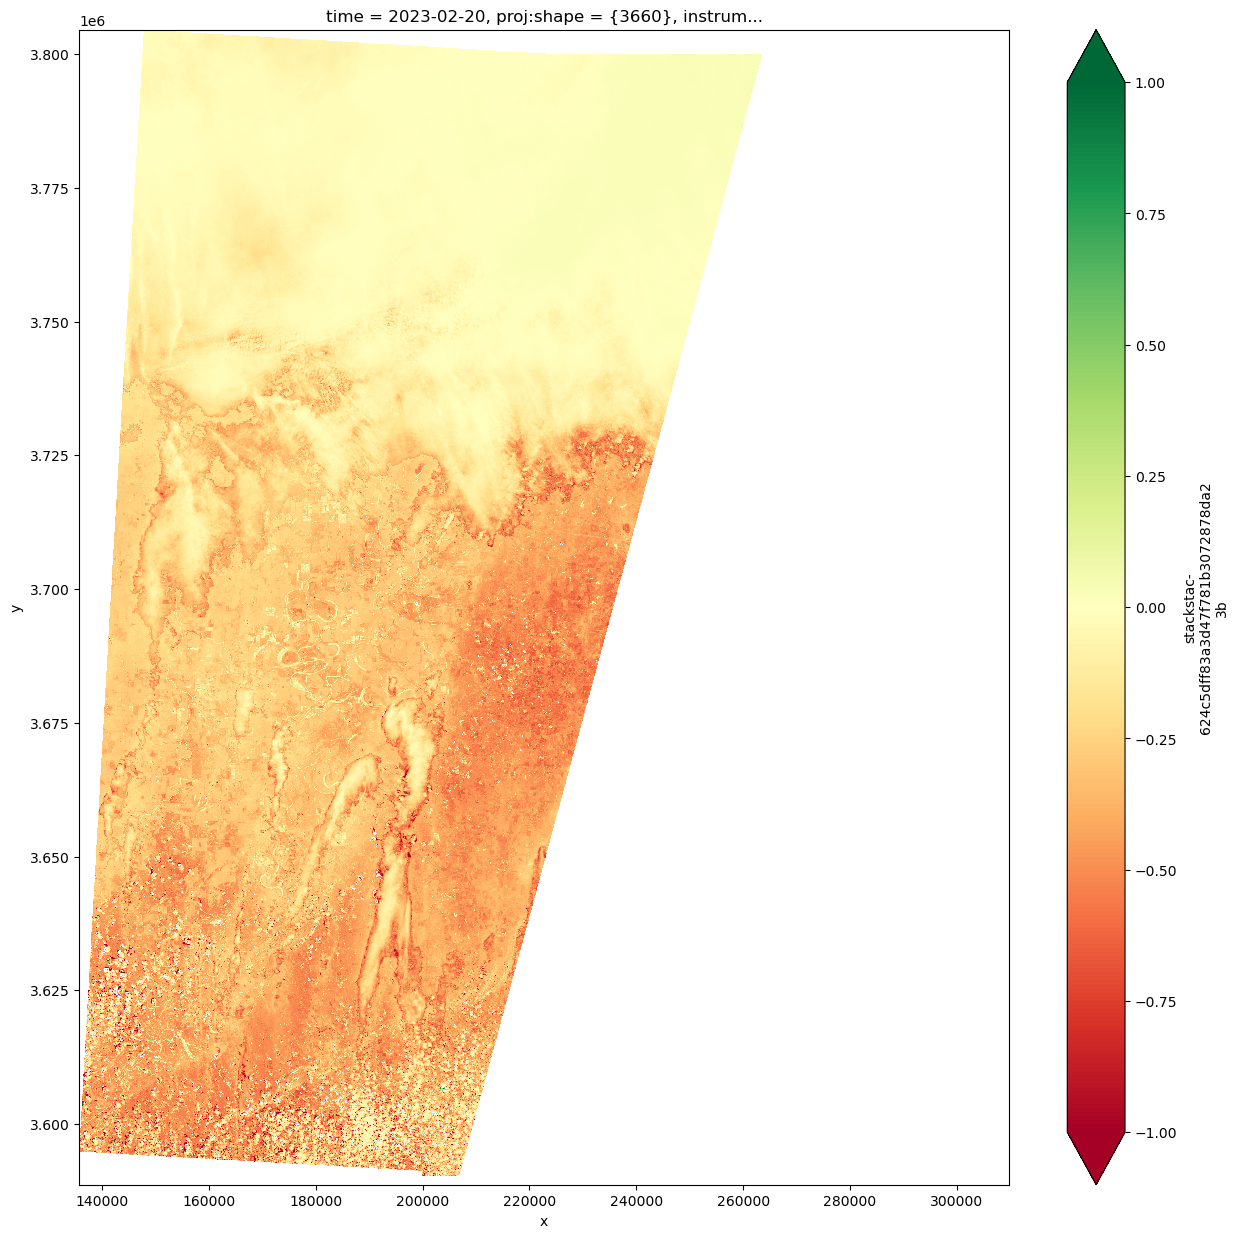

In [12]:
# Visually see the NDVI using S30 for selected location, and date.
index_array["HLSL30"].plot(vmin=-1, vmax=1, cmap="RdYlGn", figsize=(15,15))

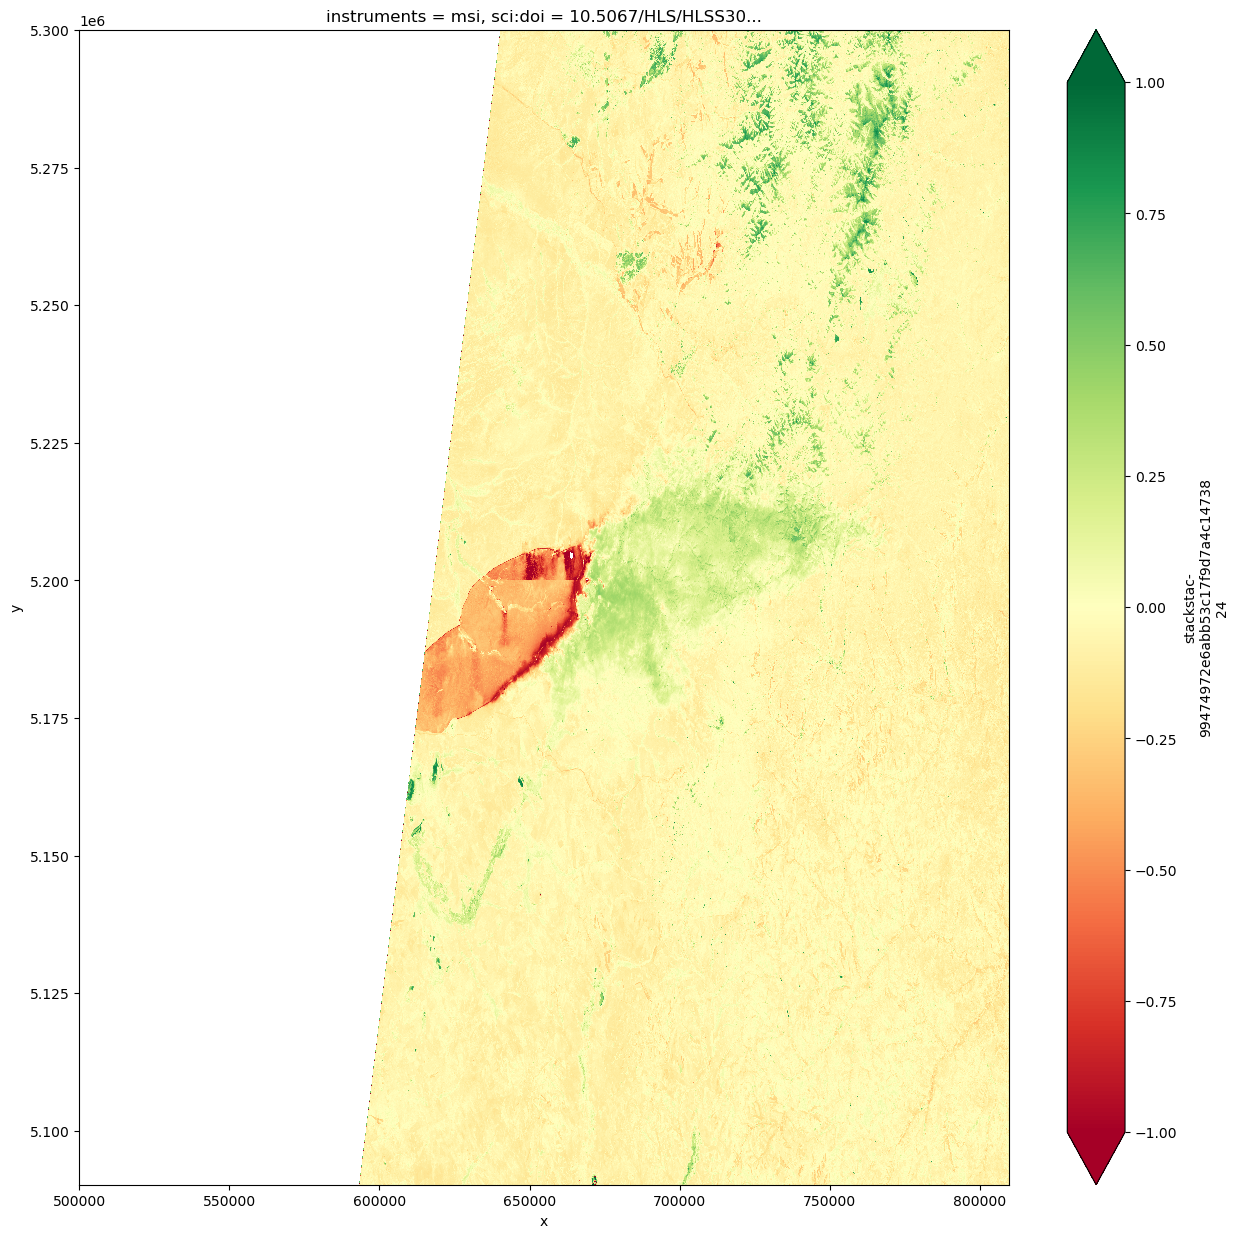

In [12]:
# Visually see the NDVI using S30 for selected location, and date.
index_array["HLSS30"].plot(vmin=-1, vmax=1, cmap="RdYlGn", figsize=(15,15))